# Data augmentation to balance by oversampling technique

In [1]:
import os
import cv2
import numpy as np
import random

# Paths to your class directories
base_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/data'
class_dirs = {
    'cup': 'cup',
    'knife': 'knife',
    'scissors': 'scissors',
    'spoon': 'spoon'
}

# Desired number of images per class (choose the maximum class count)
target_count = 1022  # Maximum number of images in any class (cup)

# Function to augment an image (simple horizontal flip, rotation, etc.)
def augment_image(image):
    # Example: apply random rotation and horizontal flip
    rows, cols = image.shape[:2]
    angle = random.choice([0, 90, 180, 270])
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    if random.choice([True, False]):
        rotated_image = cv2.flip(rotated_image, 1)
    return rotated_image

# Function to oversample the classes
def oversample_classes(base_dir, class_dirs, target_count):
    for class_name, class_dir in class_dirs.items():
        class_path = os.path.join(base_dir, class_dir)
        images = os.listdir(class_path)
        current_count = len(images)
        
        # If the class is underrepresented, oversample (augment images)
        if current_count < target_count:
            print(f'Oversampling {class_name} class from {current_count} to {target_count} images...')
            while len(images) < target_count:
                image_file = random.choice(images)
                image_path = os.path.join(class_path, image_file)
                image = cv2.imread(image_path)
                augmented_image = augment_image(image)
                new_filename = f'aug_{len(images)}_{image_file}'
                cv2.imwrite(os.path.join(class_path, new_filename), augmented_image)
                images.append(new_filename)
        else:
            print(f'{class_name} class already has {current_count} images, no need to oversample.')

# Run the oversampling
oversample_classes(base_dir, class_dirs, target_count)


cup class already has 1022 images, no need to oversample.
Oversampling knife class from 793 to 1022 images...
Oversampling scissors class from 304 to 1022 images...
Oversampling spoon class from 895 to 1022 images...


# Shuffle and Split the dataset into Train :0.7 , test:0.2 , val : 0.1 set

In [2]:
import os
import shutil
import random
from math import floor

# Paths to your balanced dataset directory
base_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/data'

# Output directories for train, test, and validation sets
output_dirs = {
    'train': '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/train',
    'test': '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/test',
    'val': '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/val'
}

# Define the split ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Create output directories if they don't exist
def create_output_dirs(output_dirs, class_names):
    for set_type, output_dir in output_dirs.items():
        for class_name in class_names:
            dir_path = os.path.join(output_dir, class_name)
            os.makedirs(dir_path, exist_ok=True)

# Function to split the dataset
def split_dataset(base_dir, output_dirs, train_ratio, test_ratio, val_ratio):
    class_names = os.listdir(base_dir)
    
    # Create the output directories
    create_output_dirs(output_dirs, class_names)
    
    # Split each class
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        
        # Calculate split sizes
        total_images = len(images)
        train_size = floor(total_images * train_ratio)
        test_size = floor(total_images * test_ratio)
        val_size = total_images - train_size - test_size
        
        # Get the splits
        train_images = images[:train_size]
        test_images = images[train_size:train_size + test_size]
        val_images = images[train_size + test_size:]
        
        # Move images to the respective directories
        for img_set, img_files in zip(['train', 'test', 'val'], [train_images, test_images, val_images]):
            for image in img_files:
                src_file = os.path.join(class_path, image)
                dest_dir = os.path.join(output_dirs[img_set], class_name)
                shutil.copy(src_file, os.path.join(dest_dir, image))
        
        print(f'Split {class_name}: {train_size} train, {test_size} test, {val_size} val')

# Run the dataset splitting
split_dataset(base_dir, output_dirs, train_ratio, test_ratio, val_ratio)


Split knife: 715 train, 204 test, 103 val
Split spoon: 715 train, 204 test, 103 val
Split cup: 715 train, 204 test, 103 val
Split scissors: 715 train, 204 test, 103 val


# Baseline Model using Svm and Hog features

- Image are resized to 224 x 224 
- Image are read in greyscale
- Hog features are extracted for each image for all splits along with its labels

Validation Accuracy: 0.7985
Validation Classification Report:
              precision    recall  f1-score   support

         cup       0.92      0.93      0.93       103
       knife       0.71      0.65      0.68       103
    scissors       0.89      0.92      0.90       103
       spoon       0.66      0.69      0.68       103

    accuracy                           0.80       412
   macro avg       0.80      0.80      0.80       412
weighted avg       0.80      0.80      0.80       412

Test Accuracy: 0.7659
Test Classification Report:
              precision    recall  f1-score   support

         cup       0.89      0.90      0.89       204
       knife       0.65      0.65      0.65       204
    scissors       0.88      0.90      0.89       204
       spoon       0.64      0.62      0.63       204

    accuracy                           0.77       816
   macro avg       0.76      0.77      0.77       816
weighted avg       0.76      0.77      0.77       816

Confusion Matrix:


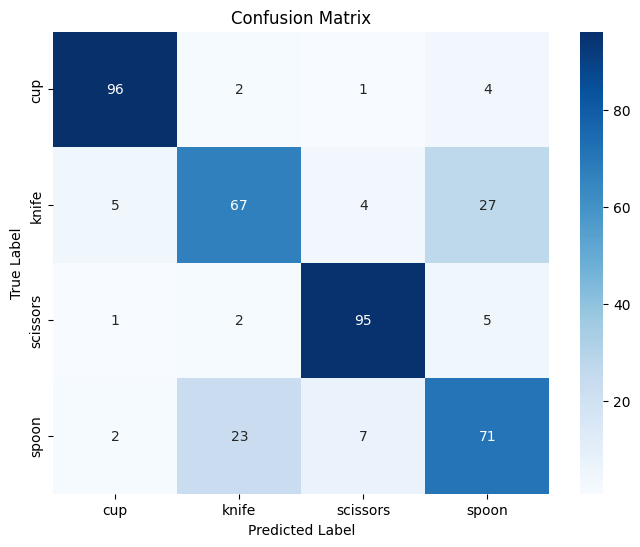

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Paths to your dataset
train_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/train'
test_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/test'
val_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/val'

# Define classes
classes = ['cup', 'knife', 'scissors', 'spoon']

# Function to load images and extract HOG features
def load_images_and_extract_features(data_dir, classes):
    data = []
    labels = []
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Resize image to a fixed size 
            image = cv2.resize(image, (224, 224))
            # Extract HOG features
            hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
            data.append(hog_features)
            labels.append(classes.index(class_name))
    return np.array(data), np.array(labels)

# Load datasets and extract features
X_train, y_train = load_images_and_extract_features(train_dir, classes)
X_test, y_test = load_images_and_extract_features(test_dir, classes)
X_val, y_val = load_images_and_extract_features(val_dir, classes)

# Create an SVM model pipeline with standard scaling
model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Validation Classification Report:')
print(classification_report(y_val, y_val_pred, target_names=classes))

# Evaluate on the test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=classes))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for validation data
plot_confusion_matrix(y_val, y_val_pred, classes)


# Basic CNN architecture 

2024-08-29 13:22:05.052968: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 13:22:05.284661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 13:22:06.603394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 2860 images belonging to 4 classes.
Found 816 images belonging to 4 classes.
Found 412 images belonging to 4 classes.


2024-08-29 13:22:09.526128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:09.649825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:09.649871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:09.653112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Epoch 1/50


2024-08-29 13:22:09.653232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:09.653254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:10.897219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:10.897302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 13:22:10.897308: I tensorflow/core/co

2857/2860 [============================>.] - ETA: 0s - loss: 1.0692 - accuracy: 0.5002

2024-08-29 13:23:00.633123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2860/2860 [==============================] - 55s 17ms/step - loss: 1.0694 - accuracy: 0.5003 - val_loss: 0.7330 - val_accuracy: 0.6875
Epoch 2/50
2860/2860 [==============================] - 48s 17ms/step - loss: 0.5421 - accuracy: 0.7605 - val_loss: 0.6100 - val_accuracy: 0.7390
Epoch 3/50
2860/2860 [==============================] - 48s 17ms/step - loss: 0.3555 - accuracy: 0.8503 - val_loss: 0.4912 - val_accuracy: 0.8076
Epoch 4/50
2860/2860 [==============================] - 48s 17ms/step - loss: 0.2360 - accuracy: 0.9045 - val_loss: 0.5172 - val_accuracy: 0.8100
Epoch 5/50
2860/2860 [==============================] - 48s 17ms/step - loss: 0.1347 - accuracy: 0.9476 - val_loss: 0.8302 - val_accuracy: 0.7880
Epoch 6/50
2860/2860 [==============================] - 48s 17ms/step - loss: 0.1143 - accuracy: 0.9647 - val_loss: 0.6785 - val_accuracy: 0.8113
Epoch 7/50
2860/2860 [==============================] - 48s 17ms/step - loss: 0.0537 - accuracy: 0.9839 - val_loss: 0.9040 - val_accura

2024-08-29 13:28:41.888591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


816/816 [==============================] - 6s 7ms/step - loss: 0.4912 - accuracy: 0.8076
Test accuracy: 0.8076
Test loss: 0.4912


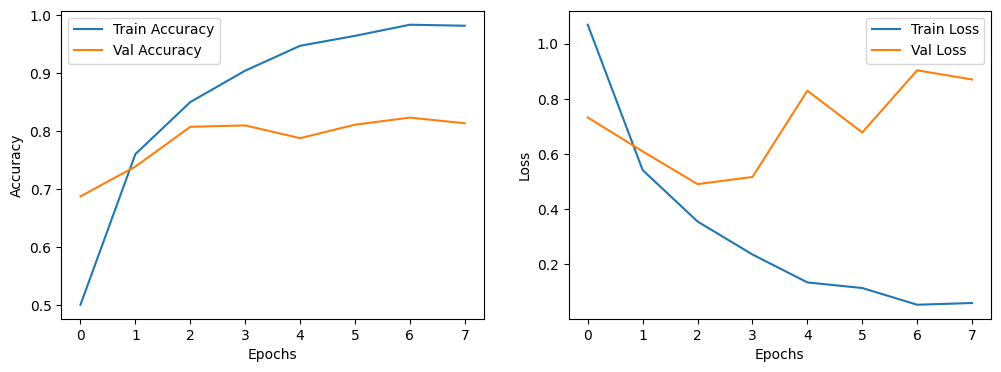

Model saved to simple_cnn_model.h5
  9/413 [..............................] - ETA: 2s 

2024-08-29 13:28:48.475283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


413/413 [==============================] - 3s 7ms/step


<Figure size 1000x1000 with 0 Axes>

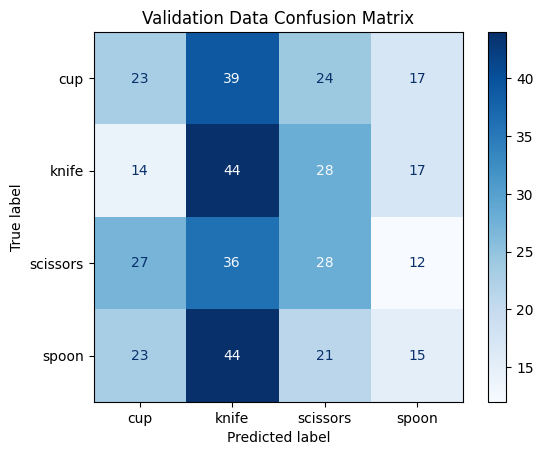

Classification Report:
              precision    recall  f1-score   support

         cup       0.26      0.22      0.24       103
       knife       0.27      0.43      0.33       103
    scissors       0.28      0.27      0.27       103
       spoon       0.25      0.15      0.18       103

    accuracy                           0.27       412
   macro avg       0.26      0.27      0.26       412
weighted avg       0.26      0.27      0.26       412



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report

# Paths to your dataset
train_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/train'
test_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/test'
val_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/val'


# Image size and batch size
img_height, img_width = 224, 224
batch_size = 1

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data= test_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_acc = model.evaluate(test_generator)
print(f'Test accuracy: {val_acc:.4f}')
print(f'Test loss: {val_loss:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model
model_path = 'simple_cnn_model.h5'
model.save(model_path)
print(f'Model saved to {model_path}')

# Function to generate and plot confusion matrix
def plot_confusion_matrix(generator, model):
    generator.reset()  # Ensure predictions start from the beginning
    predictions = model.predict(generator, steps=generator.samples // batch_size + 1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())
    
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    plt.figure(figsize=(10, 10))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Validation Data Confusion Matrix")
    plt.show()

    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"Classification Report:\n{report}")

# Plot confusion matrix for validation data
plot_confusion_matrix(val_generator, model)


# Enhancement of CNN with Canny edge + Histogram equalization and Image normalization

2024-08-29 12:27:26.348740: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 12:27:26.688181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 12:27:28.244394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-29 12:28:00.888713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 12:28:01.016

Epoch 1/50


2024-08-29 12:28:05.677688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-08-29 12:28:07.602081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-29 12:28:07.620911: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2c73c9e660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-29 12:28:07.620976: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-08-29 12:28:07.684678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 12:28:08.040583: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

2860/2860 [==============================] - 32s 9ms/step - loss: 1.1841 - accuracy: 0.4584 - val_loss: 1.0343 - val_accuracy: 0.5502
Epoch 2/50
2860/2860 [==============================] - 24s 8ms/step - loss: 0.9601 - accuracy: 0.5864 - val_loss: 0.9092 - val_accuracy: 0.5980
Epoch 3/50
2860/2860 [==============================] - 24s 8ms/step - loss: 0.8123 - accuracy: 0.6636 - val_loss: 0.8262 - val_accuracy: 0.6532
Epoch 4/50
2860/2860 [==============================] - 24s 9ms/step - loss: 0.6865 - accuracy: 0.7266 - val_loss: 0.7550 - val_accuracy: 0.6728
Epoch 5/50
2860/2860 [==============================] - 24s 8ms/step - loss: 0.5986 - accuracy: 0.7675 - val_loss: 0.7006 - val_accuracy: 0.7010
Epoch 6/50
2860/2860 [==============================] - 24s 8ms/step - loss: 0.5178 - accuracy: 0.7990 - val_loss: 0.7352 - val_accuracy: 0.6900
Epoch 7/50
2860/2860 [==============================] - 24s 8ms/step - loss: 0.4537 - accuracy: 0.8248 - val_loss: 0.6429 - val_accuracy: 0.7

2024-08-29 12:33:04.373070: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 208.52MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 12:33:04.373110: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-08-29 12:33:04.451765: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 214.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 12:33:04.451869: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out

13/13 [==============================] - 1s 40ms/step - loss: 0.5916 - accuracy: 0.7646


2024-08-29 12:33:04.977283: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 189.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 12:33:04.977359: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 189.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 12:33:04.977372: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 189.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 12:33:04.977382: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

Test accuracy: 0.7646
Test loss: 0.5916


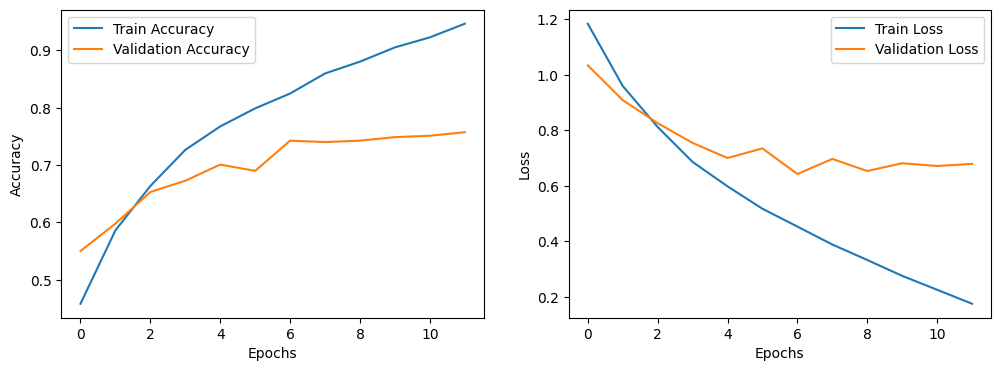

Model saved to cnn_model_with_image_processing.h5
26/26 [==============================] - 1s 29ms/step


<Figure size 1000x1000 with 0 Axes>

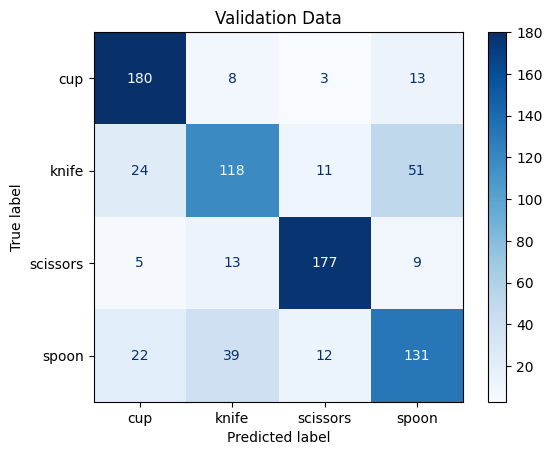

Validation Data Classification Report:
              precision    recall  f1-score   support

         cup       0.78      0.88      0.83       204
       knife       0.66      0.58      0.62       204
    scissors       0.87      0.87      0.87       204
       spoon       0.64      0.64      0.64       204

    accuracy                           0.74       816
   macro avg       0.74      0.74      0.74       816
weighted avg       0.74      0.74      0.74       816

13/13 [==============================] - 0s 19ms/step


<Figure size 1000x1000 with 0 Axes>

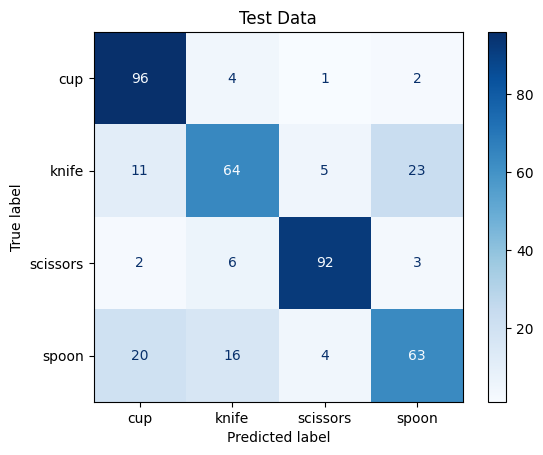

Test Data Classification Report:
              precision    recall  f1-score   support

         cup       0.74      0.93      0.83       103
       knife       0.71      0.62      0.66       103
    scissors       0.90      0.89      0.90       103
       spoon       0.69      0.61      0.65       103

    accuracy                           0.76       412
   macro avg       0.76      0.76      0.76       412
weighted avg       0.76      0.76      0.76       412



In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Paths to your dataset
train_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/train'
val_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/test'  # Now using the test set as validation
test_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/val'  # Now using the validation set as test

# Image size and batch size
img_height, img_width = 224, 224
batch_size = 1
num_classes = 4  # Adjust this based on your dataset

# Helper function to apply image processing
def process_image(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Histogram Equalization
    image = cv2.equalizeHist(image)
    
    # Apply Canny Edge Detection
    edges = cv2.Canny(image, 50, 150)
    
    # Resize image to the target size
    edges = cv2.resize(edges, (img_height, img_width))
    
    return edges / 255.0  # Normalize the image

# Load datasets
def load_dataset(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = process_image(img_path)
            images.append(image)
            labels.append(label)
    return np.array(images), tf.keras.utils.to_categorical(np.array(labels), num_classes)

X_train, y_train = load_dataset(train_dir)
X_val, y_val = load_dataset(val_dir)  # Now validation data is loaded from the original test set
X_test, y_test = load_dataset(test_dir)  # Now test data is loaded from the original validation set

# Reshape data to add channel dimension
X_train = X_train.reshape(-1, img_height, img_width, 1)
X_val = X_val.reshape(-1, img_height, img_width, 1)
X_test = X_test.reshape(-1, img_height, img_width, 1)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Validation data is now the original test set
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)  # Test data is now the original validation set
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model
model_path = 'cnn_model_with_image_processing.h5'
model.save(model_path)
print(f'Model saved to {model_path}')

# Function to generate and plot confusion matrix
def plot_confusion_matrix(X, y, model, title="Confusion Matrix"):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    class_labels = sorted(os.listdir(train_dir))
    
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    plt.figure(figsize=(10, 10))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

    # Generate and print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"{title} Classification Report:\n{report}")

# Plot confusion matrix and classification report for the interchanged validation data (original test set)
plot_confusion_matrix(X_val, y_val, model, title="Validation Data")

# Plot confusion matrix and classification report for the interchanged test data (original validation set)
plot_confusion_matrix(X_test, y_test, model, title="Test Data")


# Finetuning MobileNetV2

Epoch 1/7


2024-09-22 23:31:48.679409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-09-22 23:31:52.434781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-22 23:31:52.474271: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x4ba61ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-22 23:31:52.474304: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-22 23:31:52.566098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-22 23:31:52.890628: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

90/90 [==============================] - 36s 118ms/step - loss: 0.2355 - accuracy: 0.9171 - val_loss: 0.1280 - val_accuracy: 0.9559
Epoch 2/7
90/90 [==============================] - 6s 62ms/step - loss: 0.0266 - accuracy: 0.9930 - val_loss: 0.2262 - val_accuracy: 0.9216
Epoch 3/7
90/90 [==============================] - 6s 61ms/step - loss: 0.0081 - accuracy: 0.9990 - val_loss: 0.2134 - val_accuracy: 0.9203
Epoch 4/7
90/90 [==============================] - 6s 62ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.2643 - val_accuracy: 0.9069
Epoch 5/7
90/90 [==============================] - 5s 61ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.2796 - val_accuracy: 0.9277
Epoch 6/7
90/90 [==============================] - 5s 61ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.2233 - val_accuracy: 0.9375
Epoch 7/7
13/13 [==============================] - 0s 24ms/step - loss: 0.1741 - accuracy: 0.9563
Test accuracy: 0.9563
Test loss: 0.1741
Model saved to finetuned_mobil

<Figure size 1000x1000 with 0 Axes>

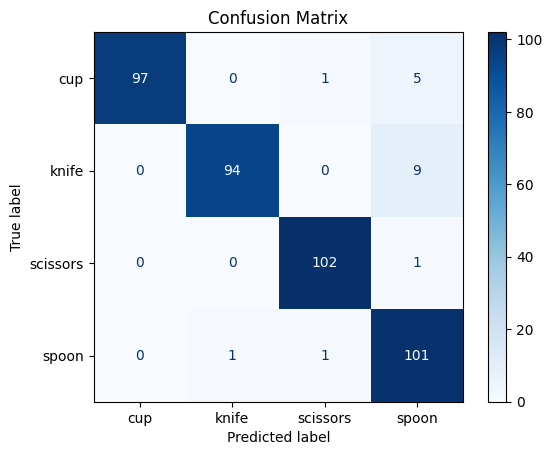

Classification Report:
               precision    recall  f1-score   support

         cup       1.00      0.94      0.97       103
       knife       0.99      0.91      0.95       103
    scissors       0.98      0.99      0.99       103
       spoon       0.87      0.98      0.92       103

    accuracy                           0.96       412
   macro avg       0.96      0.96      0.96       412
weighted avg       0.96      0.96      0.96       412



In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Paths to your dataset
# Paths to your dataset
train_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/train'
val_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/test'  # Now using the test set as validation
test_dir = '/home/ubuntu/anish/projects/ml_anhalt/final_project/kitchenware_data/val'

# Image size and batch size
img_height, img_width = 128, 128
batch_size = 32
num_classes = 4  # Adjust this based on your dataset

def process_image(image_path):
    # Load image in RGB
    image = cv2.imread(image_path)
    
    # Apply Canny Edge Detection
    edges = cv2.Canny(image, 50, 150)
    
    # Convert edges to a 3-channel format to match the input shape
    edges_colored = cv2.merge([edges, edges, edges])
    
    # Combine RGB image with edge detection output
    combined_image = cv2.addWeighted(image, 0.8, edges_colored, 0.2, 0)
    
    # Resize image to the target size
    combined_image = cv2.resize(combined_image, (img_height, img_width))
    
    return combined_image / 255.0  # Normalize the image

# Load datasets
def load_dataset(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = process_image(img_path)
            images.append(image)
            labels.append(label)
    return np.array(images), tf.keras.utils.to_categorical(np.array(labels), num_classes)

X_train, y_train = load_dataset(train_dir)
X_val, y_val = load_dataset(val_dir)
X_test, y_test = load_dataset(test_dir)

# Define the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=batch_size)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

#save model
model_path = 'finetuned_mobilenetv2.h5'
model.save(model_path)
print(f'Model saved to {model_path}')

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(os.listdir(train_dir)))

# Display the confusion matrix
plt.figure(figsize=(10, 10))
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Generate and print classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=sorted(os.listdir(train_dir)))
print("Classification Report:\n", class_report)
